# FROM 4OYD


## Question: Can we fold 3LHP and expect it to mimic the configuration of 4OYD?

In this scenario, we use __3LHP__ as template, and __4OYD__ as the source of our motif and binder and as the final target conformation we are aiming to mimic.

We will run the protocol with and without a binder. Using full CA constraints from the template (_fullcst_) or just constraints between residues belonging to the same secondary structure (_ssecst_).

We will first have a *no_design* run that entails only the __NubInitioMover__. This runs will generate poses that have to be considered as non-final, and, thus, should not be considered on their own without further processing.

After that, different design rules are tested:  

* __classicFFL:__ Rules are followed like in the original FFL. 3 Rounds of __FastDesign__ in which the binder (if any) and the motif are completely static.  
* __minimizeBinderAlternate:__ For 3 rounds, we will alternate __FastDesign__ with the classical _FFL rules_ with minimization of the _binder_. 


### Nomenclature:

* __Template:__ Structure that will accomodate the query motif.  
* __Design:__ Chain that we are designing; contains the query motif and is guided by the template info.  
* __Binder:__ If any, is whatever protein(s) bind to the query motif.  
* __Target:__ Protein that we expect our design to resemble to and to which we compare.  

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy

sns.set(font_scale=1.5);

In [30]:
def merge_rmsd_types( df, keys ):
    dataframes = []
    for k in keys["split"]:
        colIDs = copy.copy(keys["keep"])
        colIDs.append(k[0])
        wdf = df[colIDs]
        wdf = wdf.assign(temporarykey1=pd.Series([k[1]]*len(wdf[colIDs[0]])).values).copy(True)
        wdf = wdf.rename(index=str, columns={
            k[0]: keys["names"][0],
            "temporarykey1": keys["names"][1]
        })
        if ( len(k) > 2 ):
            wdf = wdf.assign(temporarykey2=pd.Series([k[2]]*len(wdf[colIDs[0]])).values).copy(True)
            wdf = wdf.rename(index=str, columns={
                "temporarykey2": keys["names"][2]
            })
        dataframes.append(wdf)
    return pd.concat(dataframes)

# classicFFL (ffl)

In [120]:
experiments = [
    ("classicFFL/binder/design_classicFFL_1_minisilent", "classicFFL/binder/ddg_evaluation.score"),
    ("classicFFL/nobinder/design_classicFFL_1_minisilent", "classicFFL/nobinder/ddg_evaluation.score")
]
definition = {
    "scores":{
        "description": "description", "design_score": "score",
        "GRMSD2Target": "GRMSD2Target",
        "LRMSD2Target": "LRMSD2Target", "LRMSDH2Target": "LRMSDH2Target", "LRMSDLH2Target": "LRMSDLH2Target"
    },
    "naming": ["", "", "binder", "", "cluster", "decoy", "experiment", "", "", ""]
}
ddg_definition = {
    "scores":{
        "description": "description", "ddg": "ddg", "post_ddg": "min_ddg",
        #"rmsd_drift": "rmsd_drift", "total_score": "dimer_score"
        "score": "dimer_score"
    },
    "naming": ["", "", "binder", "", "cluster", "decoy", "experiment", "", "", "", ""]
}
logic = {
    "keep": ["description", "binder", "cluster", "decoy", "experiment",
             #"ddg", "min_ddg", "score", "dimer_score","rmsd_drift"],
             "ddg", "min_ddg", "score", "dimer_score"],
    "split": [("GRMSD2Target",  "global", "target"),  ("LRMSD2Target",   "local", "target"),
              ("LRMSDH2Target", "local",  "htarget"), ("LRMSDLH2Target", "local", "lhtarget")],
    "names": ["rmsd", "rmsd_alignment", "rmsd_to"]
}

In [121]:
dataframes = []
for experiment in experiments:
    dlist_main = rstoolbox.api.read_rosetta_silent(experiment[0])
    df_main    = rstoolbox.api.process_from_definitions(dlist_main, definition)
    dlist_ddg  = rstoolbox.api.read_rosetta_silent(experiment[1])
    df_ddg     = rstoolbox.api.process_from_definitions(dlist_ddg, ddg_definition)
    df_ddg     = df_ddg.drop("description", axis=1)
    df         = pd.merge(df_main, df_ddg, how='left', on=['cluster', 'decoy', 'experiment', 'binder'])
    dataframes.append(df)
ffl_data      = pd.concat(dataframes)
ffl_plot_data = merge_rmsd_types( ffl_data, logic )

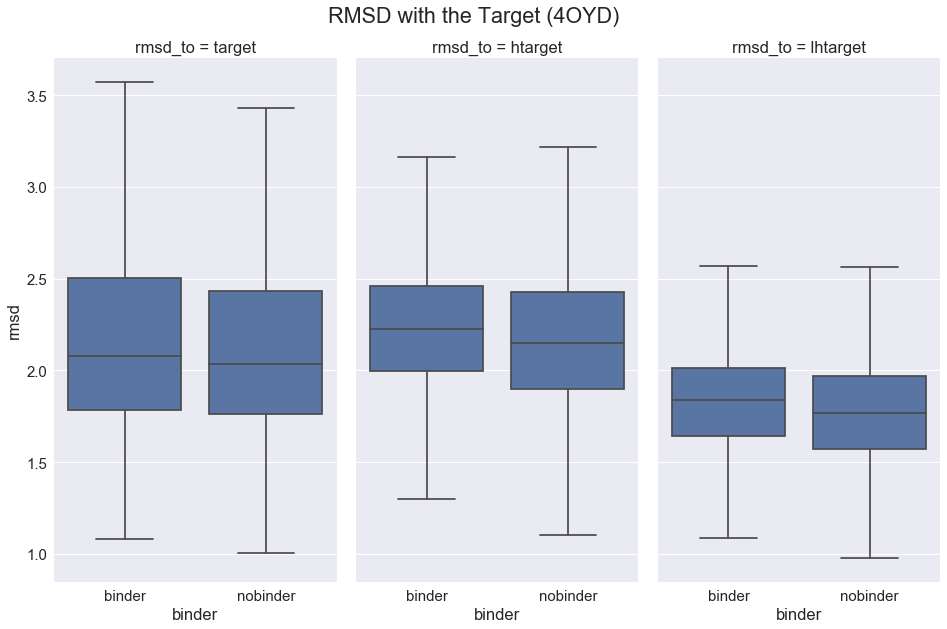

In [82]:
g = sns.FacetGrid(ffl_plot_data, col="rmsd_to", size=9, aspect=0.5)
(g.map(sns.boxplot, "binder", "rmsd", showfliers=False)
 .despine(left=True))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('RMSD with the Target (4OYD)')
sns.plt.show()

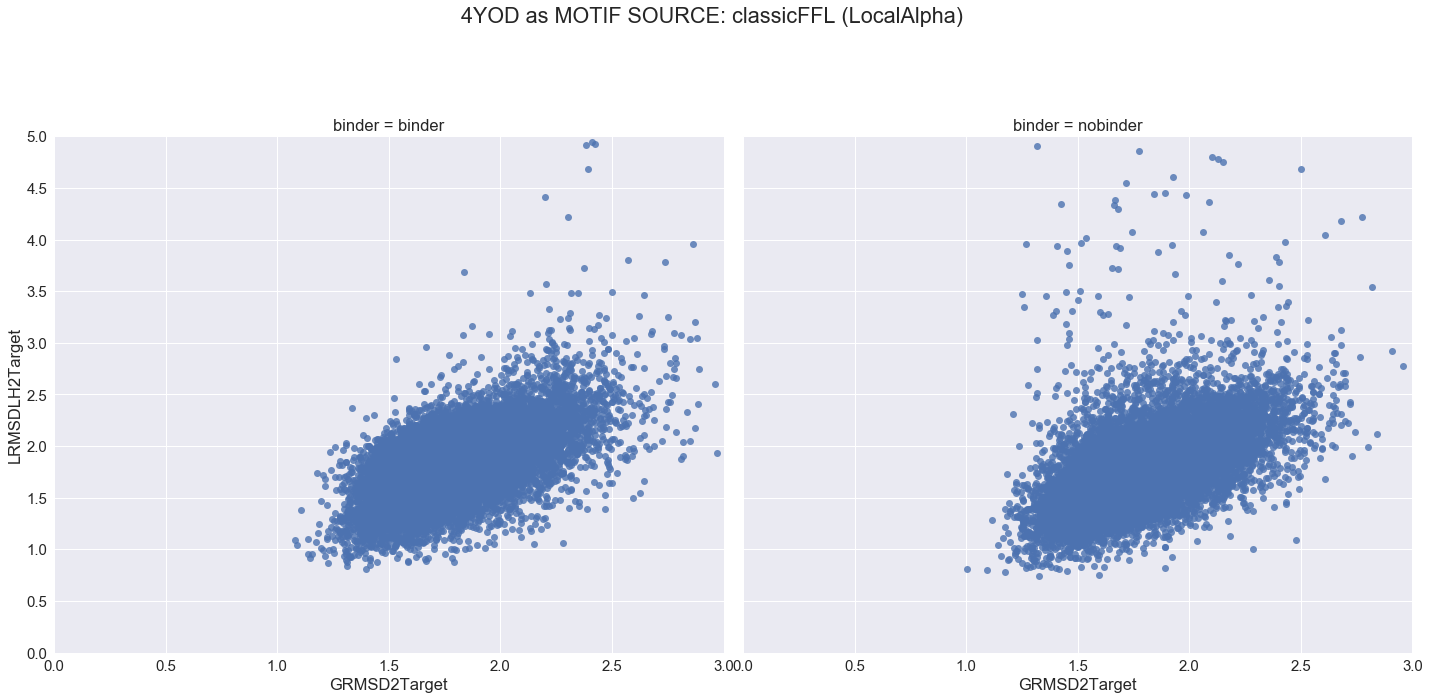

In [129]:
g = sns.lmplot(x="GRMSD2Target", y="LRMSDLH2Target", data=ffl_data, col="binder", fit_reg=False, size=10)
plt.subplots_adjust(top=0.80)
g.axes[0,0].set_ylim(0,5)
g.axes[0,0].set_xlim(0,3)
g.axes[0,0].set_yticks(np.arange(0,5.5,0.5))
g.fig.suptitle('4YOD as MOTIF SOURCE: classicFFL (LocalAlpha)')
sns.plt.show()

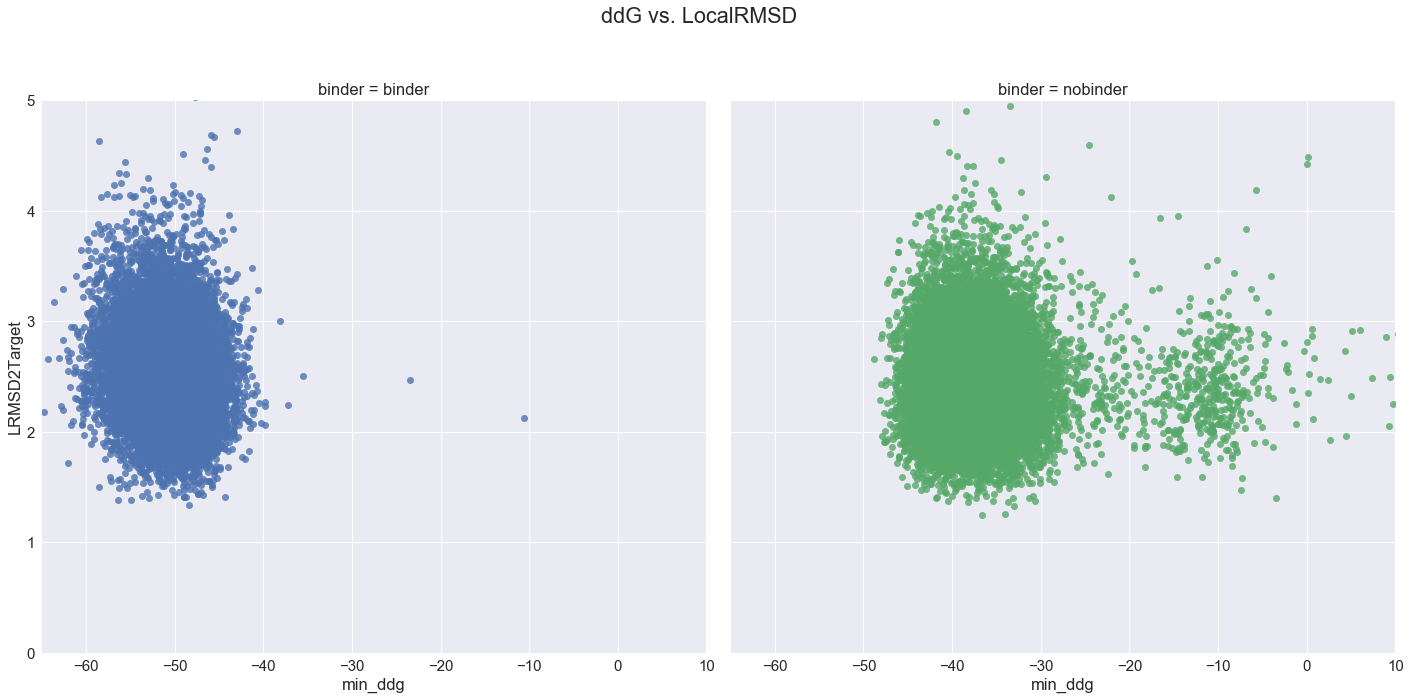

In [80]:
g = sns.lmplot(x="min_ddg", y="LRMSD2Target", col="binder", hue="binder", data=ffl_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.85)
g.axes[0,0].set_ylim(0, 5)
g.axes[0,0].set_xlim(-65,10)
g.fig.suptitle('ddG vs. LocalRMSD')
sns.plt.show()

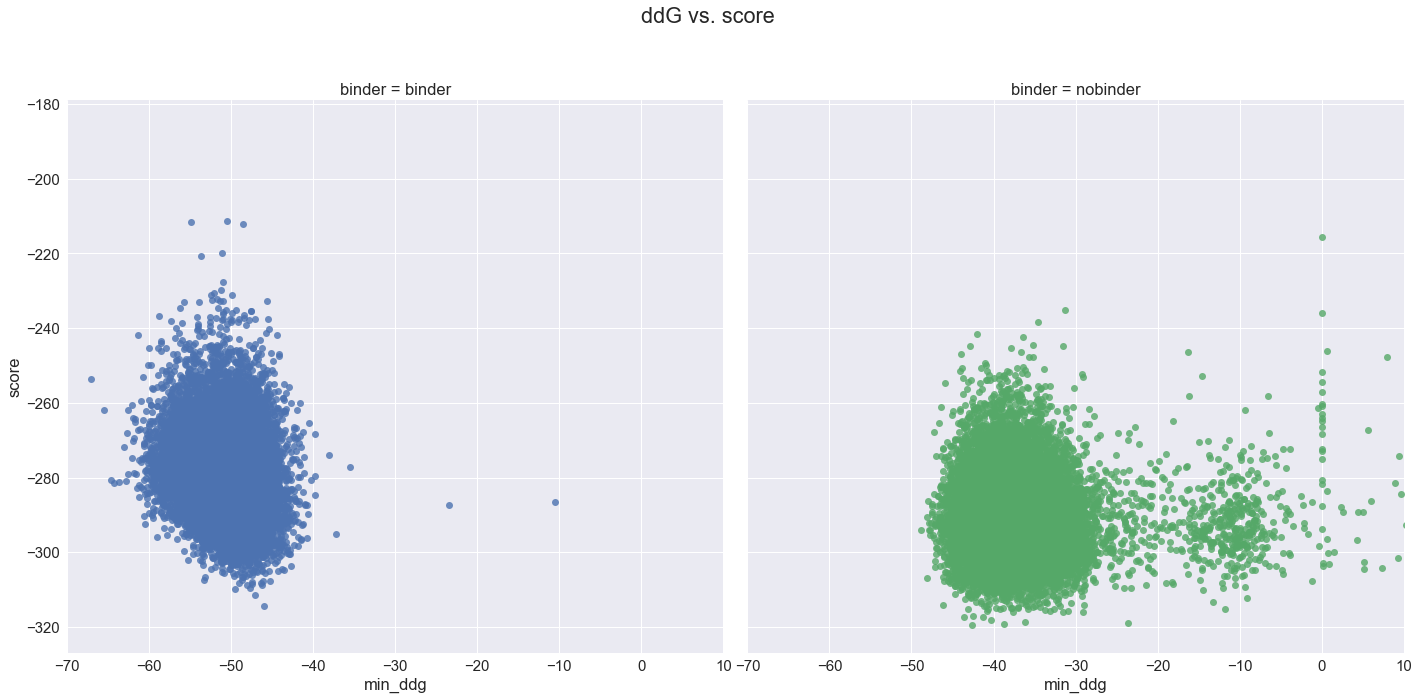

In [127]:
g = sns.lmplot(x="min_ddg", y="score", col="binder", hue="binder", data=ffl_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.85)
g.axes[0,0].set_xlim(-70,10)
g.fig.suptitle('ddG vs. score')
sns.plt.show()

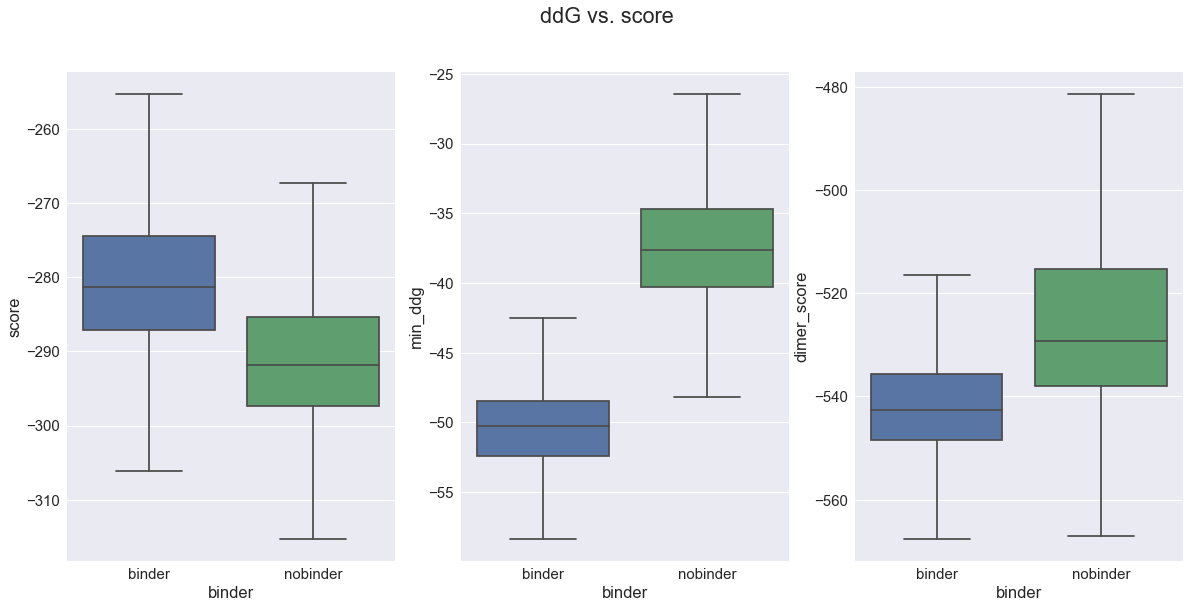

In [124]:
f, axes = plt.subplots(1, 3, figsize=(20, 9))
sns.boxplot(x="binder", y="score", data=ffl_data, showfliers=False, ax=axes[0])
sns.boxplot(x="binder", y="min_ddg", data=ffl_data, showfliers=False, ax=axes[1])
sns.boxplot(x="binder", y="dimer_score", data=ffl_data, showfliers=False, ax=axes[2])
plt.suptitle('ddG vs. score')
#f.subplots_adjust(top=0.85)
#plt.fig.suptitle('ddG vs. score')
sns.plt.show()

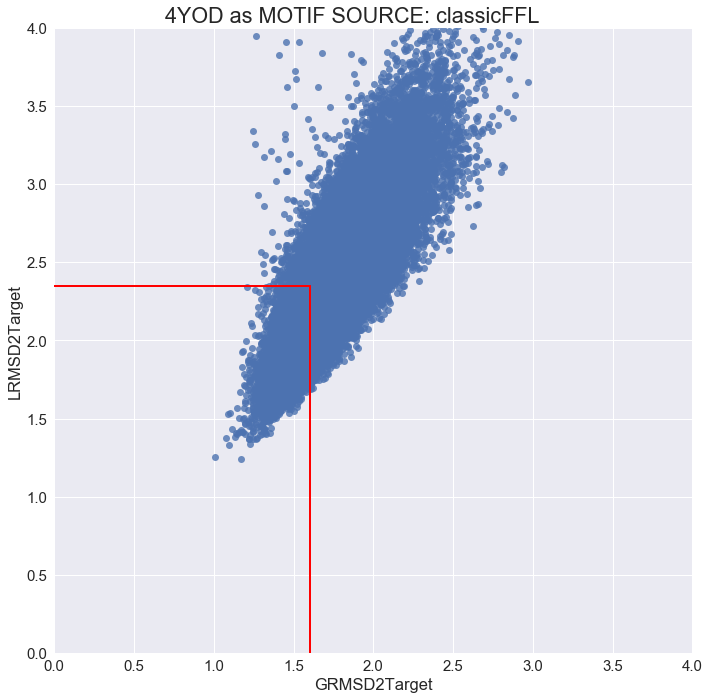

In [135]:
d = ffl_data[(ffl_data["binder"] == "binder")]
g = sns.lmplot(x="GRMSD2Target", y="LRMSD2Target", data=ffl_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.95)
g.axes[0,0].set_ylim(0,4)
g.axes[0,0].set_xlim(0,4)
#g.axes[0,0].set_yticks(np.arange(0,5.5,0.5))
sele_line_p1 = [0, 2.351]
sele_line_p2 = [1.605, 2.351]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
sele_line_p1 = [1.605, 2.351]
sele_line_p2 = [1.605, 0]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
g.fig.suptitle('4YOD as MOTIF SOURCE: classicFFL')
sns.plt.show()

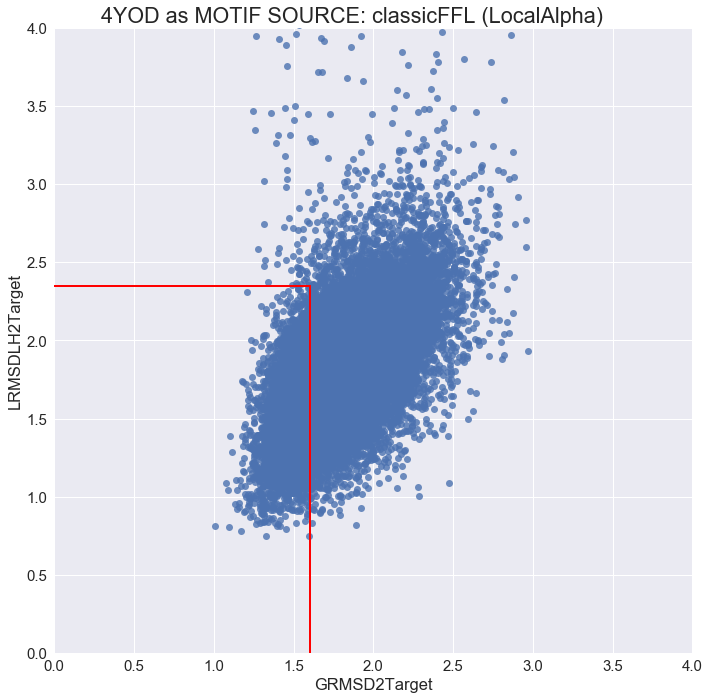

In [141]:
d = ffl_data[(ffl_data["binder"] == "binder")]
g = sns.lmplot(x="GRMSD2Target", y="LRMSDLH2Target", data=ffl_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.95)
g.axes[0,0].set_ylim(0,4)
g.axes[0,0].set_xlim(0,4)
#g.axes[0,0].set_yticks(np.arange(0,5.5,0.5))
sele_line_p1 = [0, 2.351]
sele_line_p2 = [1.605, 2.351]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
sele_line_p1 = [1.605, 2.351]
sele_line_p2 = [1.605, 0]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
g.fig.suptitle('4YOD as MOTIF SOURCE: classicFFL (LocalAlpha)')
sns.plt.show()

# minimizeBinderAlternate (mba)

In [137]:
experiments = "minimizeBinderAlternate/output/design_minimizeBinderAlternate_1_minisilent"
definition = {
    "scores":{
        "description": "description", "design_score": "score",
        "GRMSD2Target": "GRMSD2Target",
        "LRMSD2Target": "LRMSD2Target", "LRMSDH2Target": "LRMSDH2Target", "LRMSDLH2Target": "LRMSDLH2Target"
    },
    "naming": ["", "", "", "", "cluster", "decoy", "experiment", "", "", ""]
}

In [138]:
dlist    = rstoolbox.api.read_rosetta_silent(experiments)
mba_data = rstoolbox.api.process_from_definitions(dlist, definition)
mba_data.loc[mba_data["experiment"] == "minimizeBinderAlternate", "experiment"] = "mba"

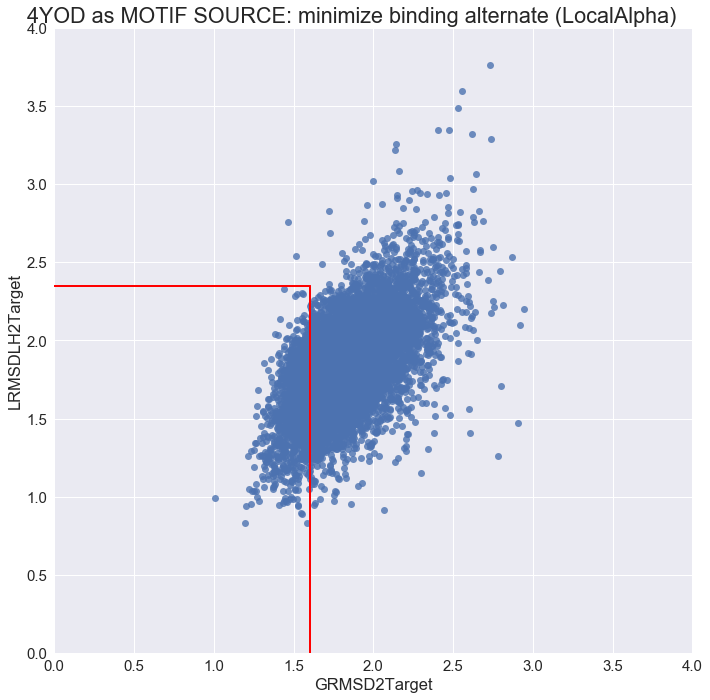

In [142]:
g = sns.lmplot(x="GRMSD2Target", y="LRMSDLH2Target", data=mba_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.95)
g.axes[0,0].set_ylim(0,4)
g.axes[0,0].set_xlim(0,4)
#g.axes[0,0].set_yticks(np.arange(0,5.5,0.5))
sele_line_p1 = [0, 2.351]
sele_line_p2 = [1.605, 2.351]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
sele_line_p1 = [1.605, 2.351]
sele_line_p2 = [1.605, 0]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
g.fig.suptitle('4YOD as MOTIF SOURCE: minimize binding alternate (LocalAlpha)')
sns.plt.show()

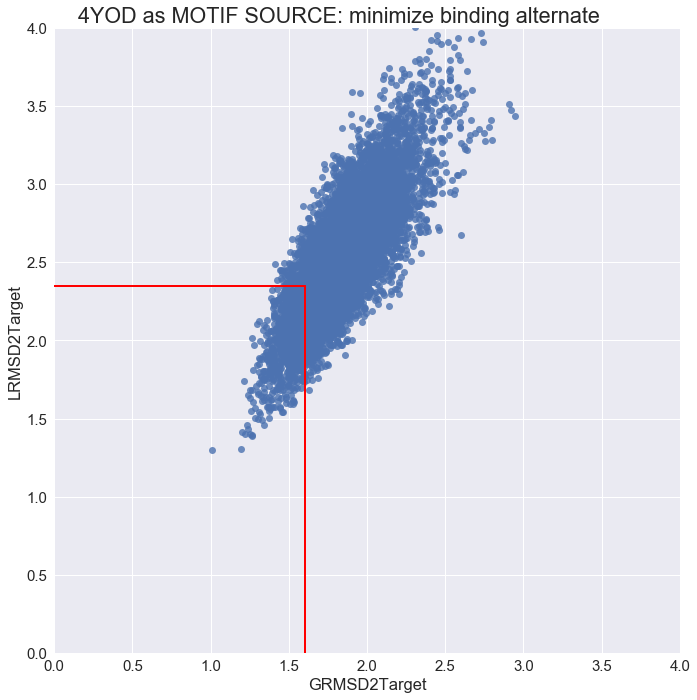

In [140]:
g = sns.lmplot(x="GRMSD2Target", y="LRMSD2Target", data=mba_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.95)
g.axes[0,0].set_ylim(0,4)
g.axes[0,0].set_xlim(0,4)
#g.axes[0,0].set_yticks(np.arange(0,5.5,0.5))
sele_line_p1 = [0, 2.351]
sele_line_p2 = [1.605, 2.351]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
sele_line_p1 = [1.605, 2.351]
sele_line_p2 = [1.605, 0]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
g.fig.suptitle('4YOD as MOTIF SOURCE: minimize binding alternate')
sns.plt.show()